In [35]:
#This script takes a initial date and final date and downloads the files needed to compute the wave activity flux (WAF)
#for that given period. NCEP/NCAR Reanalysis (Kalnay etal 1996)are used 

#libraries needed
import urllib.request
from bs4 import BeautifulSoup

def clean():   #clean enviroment
    import os
    os.system("rm -f ./tmp/*.gz ./tmp/*.nc")
    
def descarga_nc( inid, inim, iniy, find, finm, finy, variable_in, variable_out, level, tipo,lati,latf):
    #tipo controls type of data: 2 for anomalies, 3 for climatology
    # Open NCEP NCAR to access to lik to data

        url = 'http://www.esrl.noaa.gov/psd/cgi-bin/hovmoller/timeplot.ncl.pl?var='+variable_in+'&level='+str(level)+'&mon1='+str(inim)+'&mon2='+str(finm)+'&day1='+str(inid)+'&day2='+str(find)+'&yr1='+str(iniy)+'&yr2='+str(finy)+'&nyr1=&nyr2=&datatype=ncepreanalysis&type='+tipo+'&fxdlon=no&postscript=no&lon1=&lon2=&lat1='+str(lati)+'&lat2='+str(latf)+'&cint=&lowr=&highr=&size=100&color=Default&Submit=Create+Plot'     
        response = urllib.request.urlopen(url)
        data = response.read()      # a `bytes` object
        soup = BeautifulSoup(data,'html.parser') #is an xml, beautifull has a module to manage it
        link = soup.findAll('img')[-1]['src']
        #A very inefficient way to get the nc file
        link=list(link)
        link[-3]='n'
        link[-2]='c'
        link[-1]=''      
        #get nc file save as netcdf
        ruta = "./tmp/"
        url_nc="".join(link)
        urllib.request.urlretrieve(url_nc, ruta+variable_out+'.nc')
        
#begin        

clean()

#tipo controls type of data: anom
tipo='anom'

#Latitudes for the Hovmoller (could be a range or only one, in that case lati=latf)
lati=30
latf=60

#Level in mb
level=300

#initial date
iniy = 1985
inim = 12
inid = 1

#final date
finy = 1986
finm = 1
find = 15

#Variables to download

variable_in = ['uwnd','vwnd','hgt']

variable_out = ['zonalw','meridw','hgt']

for i in range(0,3):
    descarga_nc(inid, inim, iniy, find, finm, finy, variable_in[i], variable_out[i], level, tipo,lati,latf)



In [36]:
# manipulation of netCDF files
from netCDF4 import Dataset
import numpy as np

def manipular_nc(archivo,variable):
    dataset = Dataset(archivo, 'r')
    var_out = dataset.variables[variable][:]
    time = dataset.variables['time'][:]
    lon = dataset.variables['lon'][:]
    dataset.close()
    return var_out, time, lon

#begin

ruta = "./tmp/"

out_var = ['zonalw','meridw','hgt']

nc_var = ['uwnd','vwnd','hgt']

[anomu,time,lon] = manipular_nc(ruta+out_var[0]+'.nc',nc_var[0])

[anomv,time,lon] = manipular_nc(ruta+out_var[1]+'.nc',nc_var[1])

[anomhgt,time,lon] = manipular_nc(ruta+out_var[2]+'.nc',nc_var[2])

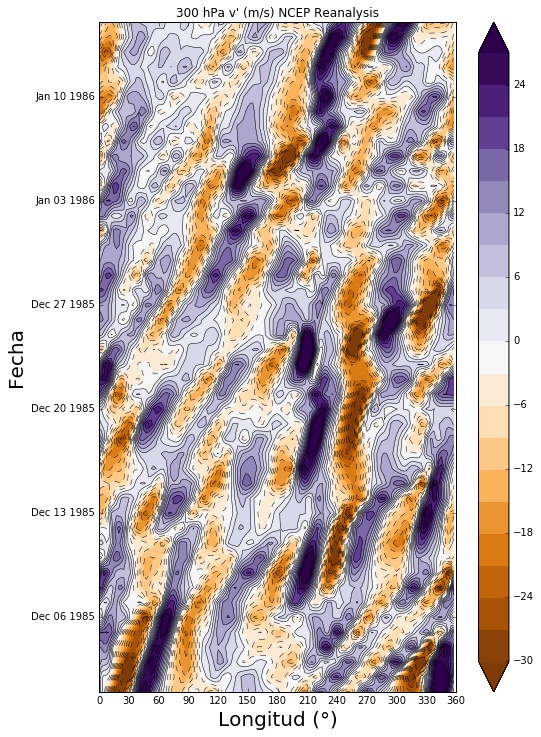

In [38]:
#plot flux along with hgt anomalies
import datetime 
import numpy as np
import matplotlib.pyplot as plt
from datetime import date

time_form=np.empty(shape=[np.size(time)],dtype=datetime.date)
time_form[:]=np.nan

for i in range(0,np.size(time_form)):
    time_form[i] = datetime.date(1800, 1, 1)+datetime.timedelta(int(time[i]/24))


%matplotlib inline

fig = plt.figure(figsize=(8, 12)) 

levels = np.arange(-30, 30, 3)
CS = plt.contourf(lon, time_form, anomv, levels,cmap=plt.get_cmap('PuOr'),extend='both',
                 hold='on')
plt.contour(lon, time_form, anomv, levels,colors='k',
                 linewidths=0.5)
plt.ylabel('Fecha',fontsize=20)
plt.xlabel('Longitud (°)',fontsize=20)
plt.xlim(0,360)
plt.xticks(np.arange(0,390,30))

plt.title("300 hPa v' (m/s) NCEP Reanalysis")

plt.colorbar(CS)

#Save in pdf

plt.savefig('Hovmoller1.pdf')

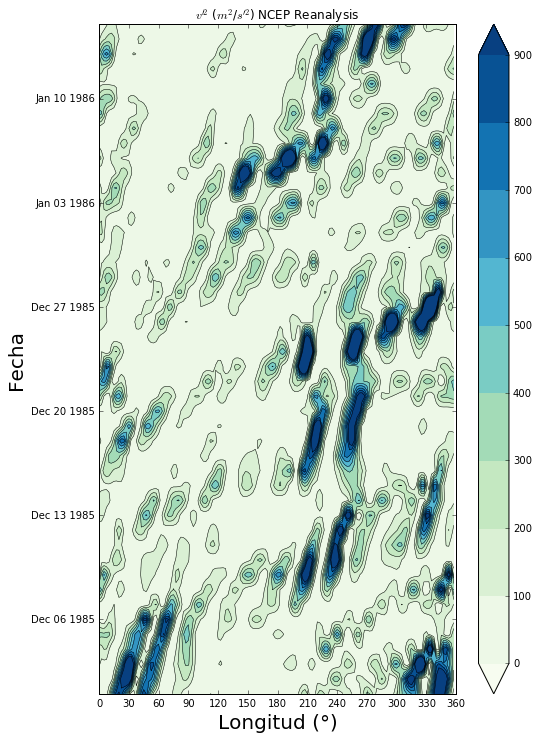

In [39]:
%matplotlib inline

ax = plt.figure(figsize=(8, 12)) 

levels = np.arange(0, 1000, 100)
CS = plt.contourf(lon, time_form, np.power(anomv,2), levels,cmap=plt.get_cmap('GnBu'),extend='both',
                 hold='on')
plt.contour(lon, time_form, np.power(anomv,2), levels,colors='k',
                 linewidths=0.5)

plt.title("$v'^ 2$ ($m^2$/$s'^2$) NCEP Reanalysis")

plt.ylabel('Fecha',fontsize=20)
plt.xlabel('Longitud (°)',fontsize=20)
plt.xlim(0,360)
plt.xticks(np.arange(0,390,30))

plt.colorbar(CS)

#Save in pdf

plt.savefig('Hovmoller2.pdf')